## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [1]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())
print(reviews.shape)

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...
(25000, 1)


In [2]:
print(labels.head())
print(labels.shape)

          0
0  positive
1  negative
2  positive
3  negative
4  positive
(25000, 1)


In [98]:
# use CountVectorizer to create a bag of words representation of the reviews (only use 10000 most frequently used words)
from sklearn.feature_extraction.text import CountVectorizer
#generate stop words list for english
stop_words = ["a", "the", "an", "is"]

vectorizer = CountVectorizer(max_features=10000, stop_words=stop_words)
train_reviews_bow = vectorizer.fit_transform(train_reviews[0])

In [3]:
#split reviews into training, testing and validation sets
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, labels, test_size=0.2, random_state=1)
train_reviews, val_reviews, train_labels, val_labels = train_test_split(train_reviews, train_labels, test_size=0.2, random_state=1)

print(train_reviews.shape)
print(train_labels.shape)
print(test_reviews.shape)
print(test_labels.shape)
print(val_reviews.shape)
print(val_labels.shape)


(16000, 1)
(16000, 1)
(5000, 1)
(5000, 1)
(4000, 1)
(4000, 1)


## I. Using SciKit's MLPClassifier
- fiddling with the hyper parameters, we managed to get this up to 88% accuracy on the test data and 87% accuracy on the validation data
- as an activation function on the hidden layer, we used the logistic sigmoid function f(x) = 1 / (1 + exp(-x))
- the best solver for weight optimization was stochastic gradient descent
- learning rate was set to be adaptive, which in the case of MLPClassifier, maintains a constant learning rate at 'learning_rate_init' while the training loss continues to decrease, but divides the current learning rate by 5 if two consecutive epochs do not decrease the training loss by at least 'tol' or fail to increase the validation score by at least 'tol' when 'early_stopping' is activated.


In [6]:
#train a neural network with one hidden layer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

clf = MLPClassifier(hidden_layer_sizes=(25,), random_state=1,activation='logistic' ,max_iter=500, solver='sgd',learning_rate='adaptive')
clf.fit(train_reviews_bow, train_labels.values.ravel())

#predict the labels for the validation set
val_reviews_bow = vectorizer.transform(val_reviews[0])
val_predicted_labels = clf.predict(val_reviews_bow)

#compute the accuracy of the predictions
val_accuracy = accuracy_score(val_labels, val_predicted_labels)
print("Validation accuracy: ", val_accuracy)


/home/mishku_vertebrate/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation accuracy:  0.876


### Testing it on the test set

In [7]:
#test the model on the test set
test_reviews_bow = vectorizer.transform(test_reviews[0])
test_predicted_labels = clf.predict(test_reviews_bow)

#compute the accuracy of the predictions
test_accuracy = accuracy_score(test_labels, test_predicted_labels)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.8794


### Testing it on new data, both positive and negative sentences

In [8]:
new_review = "This movie was atrocious."
new_review_bow = vectorizer.transform([new_review])
new_review_predicted_label = clf.predict(new_review_bow)[0]
print("Predicted label for new review: ", new_review_predicted_label)

Predicted label for new review:  negative


In [9]:
new_review = "A pleasant surprise to see such an ensemble cast in an indie debut film."
new_review_bow = vectorizer.transform([new_review])
new_review_predicted_label = clf.predict(new_review_bow)[0]
print("Predicted label for new review: ", new_review_predicted_label)

Predicted label for new review:  positive


In [10]:
new_review = "I would like to declare my contempt for these kinds of movies. They are lacking in many aspects."
new_review_bow = vectorizer.transform([new_review])
new_review_predicted_label = clf.predict(new_review_bow)[0]
print("Predicted label for new review: ", new_review_predicted_label)

Predicted label for new review:  negative


In [11]:
new_review = "Style over substance, no redeeming qualities for this show."
new_review_bow = vectorizer.transform([new_review])
new_review_predicted_label = clf.predict(new_review_bow)[0]
print("Predicted label for new review: ", new_review_predicted_label)

Predicted label for new review:  negative


In [12]:
new_review = "This debut delights its audience with some top of the line acting, for such great, coming of age actors."
new_review_bow = vectorizer.transform([new_review])
new_review_predicted_label = clf.predict(new_review_bow)[0]
print("Predicted label for new review: ", new_review_predicted_label)

Predicted label for new review:  positive


## II. Using Keras from Tensorflow


In [16]:
from sklearn.model_selection import train_test_split
labels['target'] = labels[0].factorize()[0] 
X = vectorizer.fit_transform(reviews[0]).toarray()
y = np.array(labels['target'])
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=1)

In [90]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=60, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/50
267/267 [==============================] - 2s 6ms/step - loss: 0.3640 - accuracy: 0.8584 - val_loss: 0.3046 - val_accuracy: 0.8798
Epoch 2/50
267/267 [==============================] - 2s 6ms/step - loss: 0.2125 - accuracy: 0.9231 - val_loss: 0.3450 - val_accuracy: 0.8692
Epoch 3/50
267/267 [==============================] - 2s 6ms/step - loss: 0.1560 - accuracy: 0.9459 - val_loss: 0.3196 - val_accuracy: 0.8773
Epoch 4/50
267/267 [==============================] - 2s 6ms/step - loss: 0.1159 - accuracy: 0.9634 - val_loss: 0.3456 - val_accuracy: 0.8752
Epoch 5/50
267/267 [==============================] - 2s 6ms/step - loss: 0.0854 - accuracy: 0.9749 - val_loss: 0.3797 - val_accuracy: 0.8758
Epoch 6/50
267/267 [==============================] - 2s 6ms/step - loss: 0.0608 - accuracy: 0.9841 - val_loss: 0.4044 - val_accuracy: 0.8767
Epoch 7/50
267/267 [==============================] - 2s 6ms/step - loss: 0.0420 - accuracy: 0.9908 - val_loss: 0.4541 - val_accuracy: 0.8755
Epoch 

## Plot of the learning curve, loss in each epoch, training and validation sets

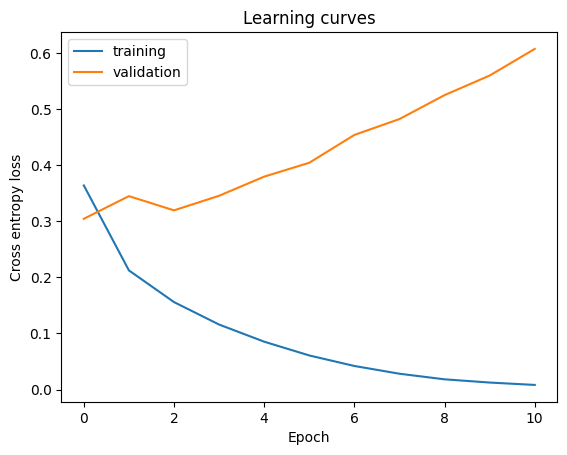

In [91]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

## Test accuracy

In [92]:
y_pred = model.predict(X_test)

# converting the predicted values to binary values based on a threshold (e.g., 0.5 for binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_pred_binary)
print("Test accuracy: ", test_accuracy)

157/157 [==============================] - 0s 897us/step
Test accuracy:  0.882


## Predictions on new data

In [93]:
def predict_sentiment(review_text, vectorizer, model):
    new_review_bow = vectorizer.transform([review_text]).toarray()
    new_review_predicted_label = model.predict(new_review_bow)
    y_pred_binary = (new_review_predicted_label > 0.5).astype(int)

    # Map binary prediction to 'positive' or 'negative'
    if y_pred_binary == 0:
        predicted_label = 'positive'
    else:
        predicted_label = 'negative'

    return predicted_label

In [94]:
new_review = "I would like to declare my contempt for these kinds of movies. They are lacking in many aspects."
predict_sentiment(new_review, vectorizer, model)

1/1 [==============================] - 0s 10ms/step


'negative'

In [95]:
new_review = "Very interesting movie, it got me into my new hobby of spanking my monkey."
predict_sentiment(new_review, vectorizer, model)

1/1 [==============================] - 0s 11ms/step


'positive'

In [96]:
new_review = "Really disturbing, very bad, kind of appaling experience."
predict_sentiment(new_review, vectorizer, model)

1/1 [==============================] - 0s 11ms/step


'negative'

In [106]:
new_review = " No creativity whatsoever, this movie sucks."
predict_sentiment(new_review, vectorizer, model)

1/1 [==============================] - 0s 12ms/step


'negative'